## Telecomunicaciones: identificar operadores ineficaces

### Descripción y objetivos

Los objetivos de este proyecto son los siguientes:
- Llevar a cabo el análisis exploratorio de datos
- Identificar operadores ineficaces
- Pobar las hipótesis estadísticas

#### 1. Preprocesamiento de datos

##### 1.1. Carga y visualización de datos

In [1]:
# Carga de librerías
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
# Carga de datos
dataset_us = pd.read_csv('/datasets/telecom_dataset_us.csv')
clients_us = pd.read_csv('/datasets/telecom_clients_us.csv')

In [3]:
# Visualiza las primeras líneas de dataset_us y su información general
print(dataset_us.head())
print()
print(dataset_us.info())

   user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   

   is_missed_call  calls_count  call_duration  total_call_duration  
0            True            2              0                    4  
1            True            3              0                    5  
2            True            1              0                    1  
3           False            1             10                   18  
4            True            3              0                   25  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Cou

Se observa que la columna date no es del tipo datetime y se presentan valores nulos en operator_id e internal.

In [4]:
# Visualiza las primeras líneas de users_us y su información general
print(clients_us.head())
print()
print(clients_us.info())

   user_id tariff_plan  date_start
0   166713           A  2019-08-15
1   166901           A  2019-08-23
2   168527           A  2019-10-29
3   167097           A  2019-09-01
4   168193           A  2019-10-16

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None


No se observan valores nulos, en cuanto al tipo de datos será necesario convertir date_start a datetime.

##### 1.2. Limpieza de datos

In [5]:
# Cambia columnas de fechas al tipo datetime
dataset_us['date'] = pd.to_datetime(dataset_us['date'])
clients_us['date_start'] = pd.to_datetime(clients_us['date_start'])
print(dataset_us['date'].dtype)
print(clients_us['date_start'].dtype)

datetime64[ns, pytz.FixedOffset(180)]
datetime64[ns]


In [6]:
# Visualiza duplicados
print('Filas duplicadas en dataset_us:', dataset_us.duplicated().sum())

Filas duplicadas en dataset_us: 4900


In [7]:
# Elimina datos duplicados 
dataset_eda = dataset_us.drop_duplicates().copy()
print('Número de duplicados:', dataset_eda.duplicated().sum())

Número de duplicados: 0


Se eliminan los registros idénticos, no aportan información nueva y pueden distorsionar los análisis estadísticos. 

In [8]:
# Verifica valores nulos o ausentes en operator_id
print('Valores nulos en operator_id:', dataset_eda['operator_id'].isnull().sum())
print('Porcentaje de valores nulos:', 
      (dataset_eda['operator_id'].isnull().mean() * 100).round(2), '%')


Valores nulos en operator_id: 7456
Porcentaje de valores nulos: 15.22 %


In [9]:
# Crea copia del dataset limpio excluyendo valores nulos
dataset_op = dataset_eda[dataset_eda['operator_id'].notnull()].copy()

In [10]:
# Verifica valores nulos o ausentes en internal de dataset_operators
print('Valores nulos en internal:', dataset_op['internal'].isnull().sum())
print('Porcentaje de valores nulos:', 
      (dataset_op['internal'].isnull().mean() * 100).round(2), '%')
print(dataset_op.shape)

Valores nulos en internal: 55
Porcentaje de valores nulos: 0.13 %
(41546, 9)


In [11]:
# Elimina valores nulos en internal en el dataset para análisis por operador
dataset_op = dataset_op[dataset_op['internal'].notnull()]
print(dataset_op.shape)

(41491, 9)


El análisis exploratorio de datos (EDA) se realizará sobre una versión del dataset original sin duplicados, dataset_eda, con el objetivo de obtener una visión global del comportamiento del sistema, incluyendo tanto llamadas con operador asignado como aquellas sin asignación.

Para el análisis del desempeño de los operadores, se eliminan las filas con valores nulos en operator_id e internal, ya que no pueden atribuirse de forma confiable a ningún operador ni permiten determinar si la llamada fue interna o externa. Además, su inclusión podría distorsionar métricas clave, como la proporción de llamadas perdidas o la carga de trabajo por operador.
Tras esta limpieza, se conserva aproximadamente el 85 % del dataset original, volumen suficiente para garantizar la representatividad del análisis.

#### 2. Análisis exploratorio de datos

In [12]:
# Visualiza dataset_eda
dataset_eda.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1


In [13]:
# Nivel de actividad
# Volumen de llamadas
print('Número total de llamadas:', dataset_eda['calls_count'].sum())
# Número de usuarios únicos
print('Número de usuarios únicos:', dataset_eda['user_id'].nunique())
# Número de operadores únicos
print('Número de operadores únicos:', dataset_eda['operator_id'].nunique())


Número total de llamadas: 806709
Número de usuarios únicos: 307
Número de operadores únicos: 1092


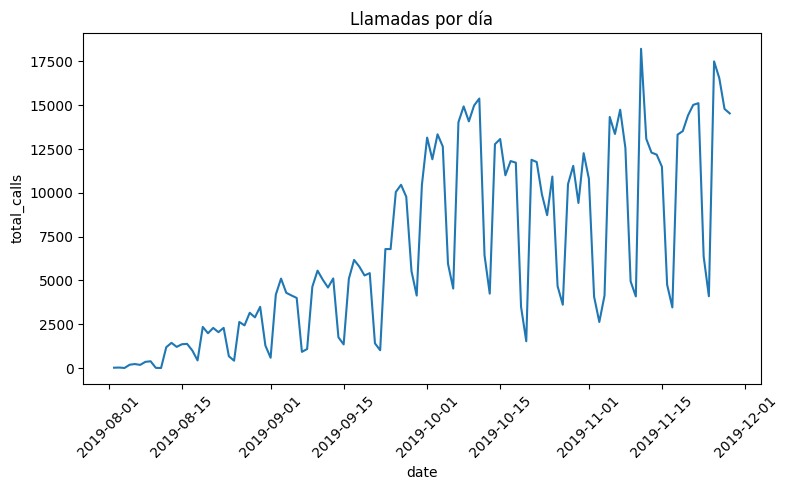

In [14]:
# Llamadas por día
calls_per_day = dataset_eda.groupby('date')['calls_count'].sum().reset_index(name='total_calls')
plt.figure(figsize=(8, 5))
sns.lineplot(data=calls_per_day, x='date', y='total_calls')
plt.title('Llamadas por día')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
# Crear columna con nombre del día de la semana
calls_per_day['day_of_week'] = calls_per_day['date'].dt.day_name()
# Agrupa por dia de la semana y calcula el promedio
avg_day_of_week = calls_per_day.groupby('day_of_week')['total_calls'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
avg_day_of_week

day_of_week
Monday       8230.470588
Tuesday      8921.352941
Wednesday    8424.588235
Thursday     8750.411765
Friday       7797.000000
Saturday     3138.176471
Sunday       2191.470588
Name: total_calls, dtype: float64


Se observa una tendencia creciente en el número de llamadas y se identifica un patrón semanal, mayor actividad de lunes a viernes y una caída considerable el fin de semana.

Total de llamadas entrantes: 197845
Total de llamadas salientes: 608864


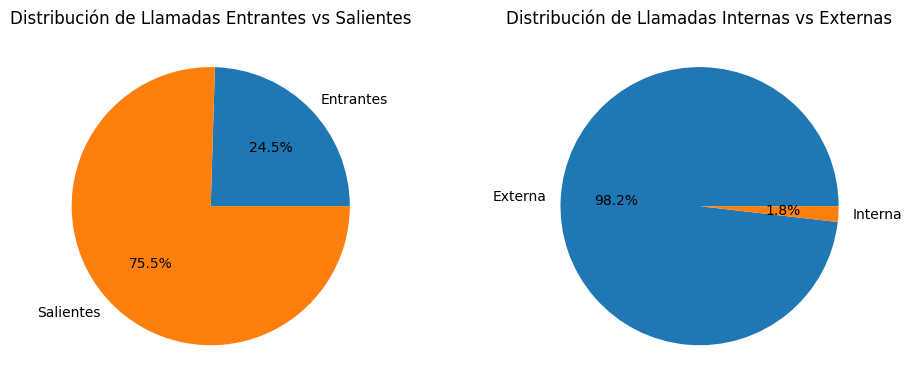

In [16]:
# Volumen de llamadas entrantes vs salientes
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
direction_counts = dataset_eda.groupby('direction')['calls_count'].sum().reset_index()
plt.pie(direction_counts['calls_count'].values, labels=['Entrantes', 'Salientes'], 
        autopct='%1.1f%%')
plt.title('Distribución de Llamadas Entrantes vs Salientes')
print('Total de llamadas entrantes:', direction_counts.iloc[0, 1])
print('Total de llamadas salientes:', direction_counts.iloc[1, 1])

# Porcentaje de llamadas internas vs externas
plt.subplot(1, 2, 2)
internal_counts = dataset_eda.groupby('internal')['calls_count'].sum().reset_index()
plt.pie(internal_counts['calls_count'].values, labels=['Externa', 'Interna'], autopct='%1.1f%%')
plt.title('Distribución de Llamadas Internas vs Externas')
plt.tight_layout()
plt.show()


La proporción de llamadas salientes es mayor que las entrantes, 75.5%.

In [17]:
# Proporción de la dirección de las llamadas
print('Total de llamadas internas:', internal_counts.iloc[1, 1])
print('Total de llamadas externas:', internal_counts.iloc[0, 1])


Total de llamadas internas: 14655
Total de llamadas externas: 791829


Las llamadas externas son el 98.2% del total de las llamadas.    

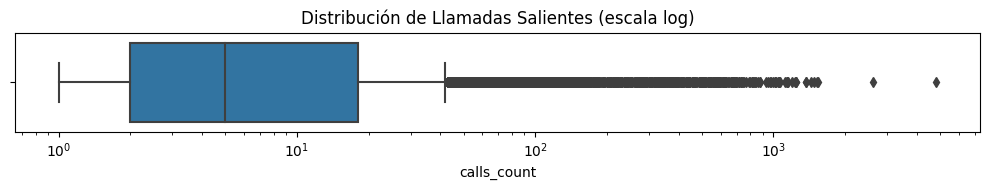

count    28999.000000
mean        20.996034
std         70.427300
min          1.000000
25%          2.000000
50%          5.000000
75%         18.000000
max       4817.000000
Name: calls_count, dtype: float64

In [18]:
# Distribución de llamadas salientes
calls_out = dataset_eda[dataset_eda['direction'] == 'out']
plt.figure(figsize=(10, 2))
sns.boxplot(calls_out['calls_count'])
plt.title('Distribución de Llamadas Salientes (escala log)')
plt.xscale('log')
plt.tight_layout()
plt.show()

calls_out['calls_count'].describe()

La mayoría de los registros tienen entre 1 y 18 llamadas, se evidencian también outliers con valores muy altos que indican una actividad inusual. 

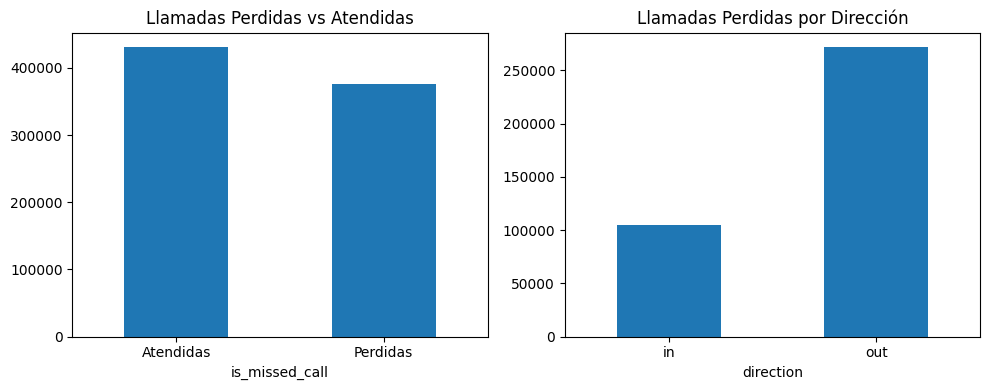

Número de llamadas perdidas: 375918
Porcentaje de llamadas perdidas: 46.6%

Llamadas perdidas entrantes: 104323
Porcentaje de llamadas perdidas entrantes: 27.8%


In [19]:
# Volumen de llamadas perdidas entrantes 
# Llamadas perdidas vs.atendidas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
dataset_eda.groupby('is_missed_call')['calls_count'].sum().plot(kind='bar')
plt.title('Llamadas Perdidas vs Atendidas')
plt.xticks([0, 1], ['Atendidas', 'Perdidas'], rotation=0)

# Llamadas perdidas por dirección (entrantes, salientes)
plt.subplot(1, 2, 2)
missed_by_direction = dataset_eda[dataset_eda['is_missed_call'] == True]
missed_by_direction_ = missed_by_direction.groupby('direction')['calls_count'].sum()
missed_by_direction_.plot(kind='bar')
plt.title('Llamadas Perdidas por Dirección')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

missed_calls = dataset_eda[dataset_eda['is_missed_call'] == True]['calls_count'].sum()
missed_rate = missed_calls / dataset_eda['calls_count'].sum() * 100
print(f'Número de llamadas perdidas: {missed_calls}')
print(f'Porcentaje de llamadas perdidas: {missed_rate:.1f}%')
print()
print(f"Llamadas perdidas entrantes: {missed_by_direction_.loc['in']}")
print(f"Porcentaje de llamadas perdidas entrantes: {(missed_by_direction_.loc['in'] / missed_calls * 100):.1f}%")


El volumen de llamadas perdidas salientes es casi 3 veces el de las salientes. 

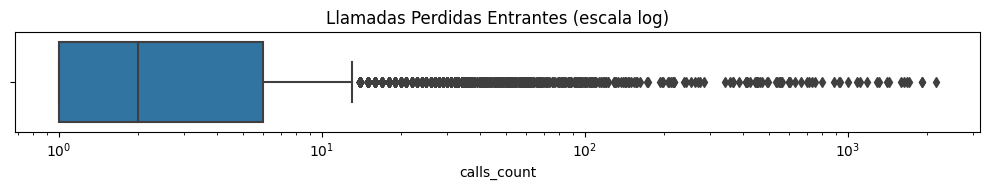

Número de llamadas perdidas entrantes: 104323

count    7887.000000
mean       13.227209
std        79.569922
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max      2168.000000
Name: calls_count, dtype: float64


In [20]:
# Distribución de llamadas perdidas entrantes
missed_calls_in = dataset_eda[(dataset_eda['is_missed_call'] == True) & (dataset_eda['direction'] == 'in')]
plt.figure(figsize=(10, 2))
sns.boxplot(missed_calls_in['calls_count'])
plt.title('Llamadas Perdidas Entrantes (escala log)')
plt.xscale('log')
plt.tight_layout()
plt.show()
print('Número de llamadas perdidas entrantes:', missed_calls_in['calls_count'].sum())
print()
print(missed_calls_in['calls_count'].describe())    

La mayoría de los registros muestran una mediana de 2 llamadas perdidas entrantes, con valores extremos muy elevados.

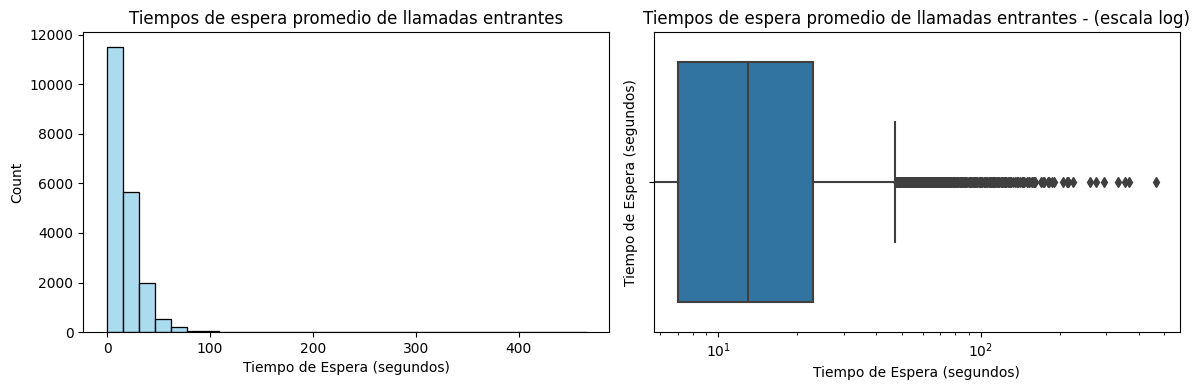

Estadísticas de tiempo de espera para llamadas entrantes:
count    20003.000000
mean        17.063890
std         17.017416
min          0.000000
25%          7.000000
50%         13.000000
75%         23.000000
max        465.000000
Name: wait_time_mean, dtype: float64


In [21]:
# Tiempo de espera llamadas entrantes

# Filtra solo llamadas entrantes y crea una copia
incoming_calls = dataset_eda[dataset_eda['direction'] == 'in'].copy()

# Crea columna con el tiempo de espera en incoming_calls
incoming_calls['wait_time'] = incoming_calls['total_call_duration'] - incoming_calls['call_duration']

# Crea columna con el tiempo de espera promedio para llamadas entrantes
incoming_calls['wait_time_mean'] = (incoming_calls['wait_time'] / incoming_calls['calls_count']).astype(int)

# Crea histograma de distribución de tiempos de espera promedio para llamadas entrantes
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(incoming_calls['wait_time_mean'], bins=30, alpha=0.7, color='skyblue')
plt.title('Tiempos de espera promedio de llamadas entrantes')
plt.xlabel('Tiempo de Espera (segundos)')

# Boxplot para ver outliers
plt.subplot(1, 2, 2)
sns.boxplot(incoming_calls['wait_time_mean'])
plt.xscale('log')
plt.title('Tiempos de espera promedio de llamadas entrantes - (escala log)')
plt.ylabel('Tiempo de Espera (segundos)')
plt.xlabel('Tiempo de Espera (segundos)')

plt.tight_layout()
plt.show()

# Muestra estadísticas descriptivas
print("Estadísticas de tiempo de espera para llamadas entrantes:")
print(incoming_calls['wait_time_mean'].describe())


La distribución es sesgada, los registros muestran una mediana de 13 segundos en los tiempos de espera y se observan outliers con valores altos de hasta 465 seg.

#### 3. Identificación de operadores ineficaces

**Llamadas perdidas entrantes**

count    239.000000
mean       5.542617
std       10.674733
min        0.088028
25%        0.813062
50%        1.990050
75%        5.409357
max      100.000000
Name: rate_missed_calls, dtype: float64


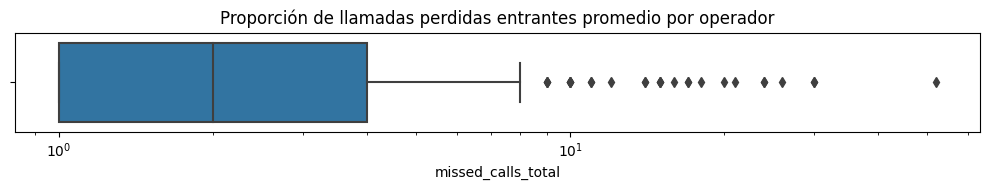

In [22]:
# Estima la tasa promedio de llamadas perdidas entrantes por operador

# Llamadas perdidas entrantes por operador en dataset_op
missed_calls_df = dataset_op[(dataset_op['is_missed_call'] == True) & (dataset_op['direction'] == 'in')]
missed_calls_per_op = missed_calls_df.groupby('operator_id')['calls_count'].sum().reset_index(name='missed_calls_total')

# Calcula solo llamadas entrantes por operador
calls_in = dataset_op[dataset_op['direction'] == 'in']
calls_in_by_op = calls_in.groupby('operator_id')['calls_count'].sum().reset_index(name='calls_total')

# Une los datasets 
missed_calls_merged = calls_in_by_op.merge(missed_calls_per_op, on='operator_id', how='left')

# Crea una nueva columna con la tasa de llamadas perdidas entrantes por operador
missed_calls_merged['rate_missed_calls'] = missed_calls_merged['missed_calls_total'] / missed_calls_merged['calls_total'] * 100

print(missed_calls_merged['rate_missed_calls'].describe())

# Distribución de promedio de llamadas perdidas por operador
plt.figure(figsize=(10, 2))
sns.boxplot(data=missed_calls_per_op, x='missed_calls_total')
plt.title("Proporción de llamadas perdidas entrantes promedio por operador")
plt.xscale('log')
plt.tight_layout()
plt.show()


La media de llamadas entrantes que no fueron atendidas, calculada por cada operador, es de aproximadamente 2 llamadas.  Se observan valores extremos de hasta 100 llamadas.

count     96.000000
mean      12.125716
std       14.544504
min        2.777778
25%        4.000000
50%        7.059801
75%       12.708333
max      100.000000
Name: rate_missed_calls, dtype: float64


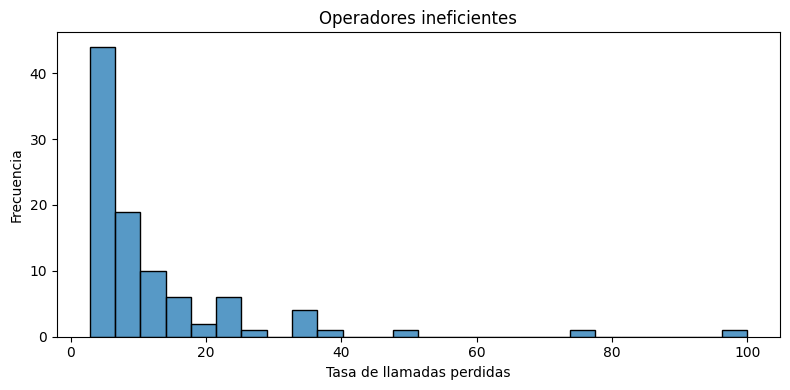

In [23]:
# Identifica operadores ineficientes de llamadas perdidas entrantes

# Selecciona valores por encima del percentil 60
p_60_ = missed_calls_merged['rate_missed_calls'].quantile(0.60)
missed_calls_inef = missed_calls_merged[missed_calls_merged['rate_missed_calls'] >= p_60_]
print(missed_calls_inef['rate_missed_calls'].describe())

# Distribución de tasas de llamadas perdidas entrantes de operadores ineficientes
plt.figure(figsize=(8, 4))
sns.histplot(data=missed_calls_inef, x='rate_missed_calls')
plt.title("Operadores ineficientes")
plt.xlabel("Tasa de llamadas perdidas")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


La tasa media de llamadas perdidas entrantes de los operadores con bajo rendimiento es de aproximadamente 7.  La mayoría de operadores tienen hasta 13 llamadas, hay casos atípicos con valores extremos.

In [24]:
# Impacto de los operadores ineficientes en las llamadas perdidas entrantes totales

# Llamadas perdidas entrantes de los operadores menos eficientes
missed_calls_op_top = missed_calls_per_op[missed_calls_per_op['operator_id'].isin(missed_calls_inef['operator_id'])]['missed_calls_total'].sum()
print('Llamadas perdidas entrantes de los operadores ineficientes:', missed_calls_op_top)

# Total de llamadas perdidas entrantes
total_missed_calls = missed_calls_per_op['missed_calls_total'].sum()

impact_mc = missed_calls_op_top / total_missed_calls * 100

print(f"El {impact_mc:.2f}% de las llamadas perdidas se concentra en el top de operadores menos eficientes")

Llamadas perdidas entrantes de los operadores ineficientes: 350
El 37.84% de las llamadas perdidas se concentra en el top de operadores menos eficientes


**Tiempo de espera en llamadas entrantes**

count      754.000000
mean      1749.183545
std       1217.131297
min         68.367347
25%        939.878234
50%       1443.050193
75%       2183.888889
max      11550.000000
Name: wait_time_by_call, dtype: float64


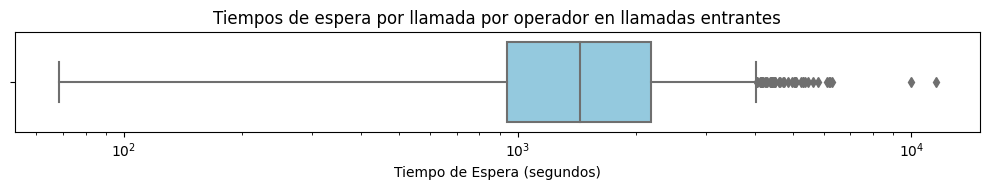

In [25]:
# Tiempo de espera en llamadas entrantes por operador

# Filtra solo llamadas entrantes y crea una copia
incoming_calls_ = dataset_op[dataset_op['direction'] == 'in'].copy()

# Crea columna con el tiempo de espera en incoming_calls_op
incoming_calls_['wait_time'] = incoming_calls_['total_call_duration'] - incoming_calls_['call_duration']

# Agrupa por operador y calcula los tiempo de espera de las llamadas entrantes
wait_time_per_op = incoming_calls_.groupby('operator_id')['wait_time'].sum().reset_index()

# Une las llamadas por operador con los tiempos de espera 
wait_time_merged = calls_in_by_op.merge(wait_time_per_op, on='operator_id')

# Crea una nueva columna con el tiempo de espera por llamada
wait_time_merged['wait_time_by_call'] = wait_time_merged['wait_time'] / wait_time_merged['calls_total'] * 100

print(wait_time_merged['wait_time_by_call'].describe())

# Crea histograma de distribución de tiempos de espera por llamada para llamadas entrantes por operador
plt.figure(figsize=(10, 2))
sns.boxplot(wait_time_merged['wait_time_by_call'], color='skyblue')
plt.title('Tiempos de espera por llamada por operador en llamadas entrantes')
plt.xlabel('Tiempo de Espera (segundos)')
plt.xscale('log')
plt.tight_layout()
plt.show()


count      302.000000
mean      2836.621637
std       1219.772097
min       1672.000000
25%       1971.250000
50%       2489.843750
75%       3393.167702
max      11550.000000
Name: wait_time_by_call, dtype: float64


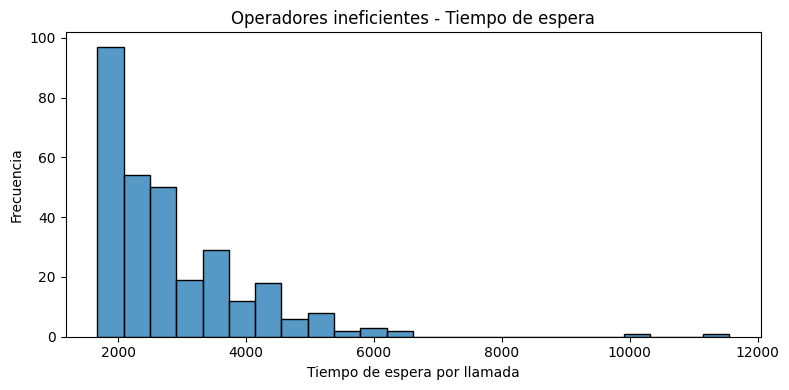

In [26]:
# Identifica operadores ineficaces en el tiempo de espera por operador

# Selecciona valores por encima del percentil 60
p60 = wait_time_merged['wait_time_by_call'].quantile(0.60)
wait_time_inef = wait_time_merged[wait_time_merged['wait_time_by_call'] >= p60]
print(wait_time_inef['wait_time_by_call'].describe())

# Distribución de tiempos de espera de llamadas entrantes de operadores ineficientes
plt.figure(figsize=(8, 4))
sns.histplot(data=wait_time_inef, x='wait_time_by_call')
plt.title("Operadores ineficientes - Tiempo de espera")
plt.xlabel("Tiempo de espera por llamada")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

In [27]:
# Impacto de los operadores ineficientes en el tiempo de espera de las llamadas entrantes

# Tiempo de espera de llamadas entrantes del percentil ineficiente
wait_time_op_top_ = wait_time_merged[wait_time_merged['operator_id'].isin(wait_time_inef['operator_id'])]['calls_total'].sum()

# Total de tiempo de espera de llamadas entrantes
total_wait_time = wait_time_merged['calls_total'].sum()

impact_wt = wait_time_op_top_ / total_wait_time * 100
print(f"El top de operadores menos eficientes es responsable del {impact_wt:.2f}% del tiempo de espera de las llamadas entrantes")


El top de operadores menos eficientes es responsable del 27.13% del tiempo de espera de las llamadas entrantes


**Llamadas salientes**

count      882.000000
mean       689.731293
std       3122.953946
min          1.000000
25%         11.000000
50%         90.000000
75%        597.250000
max      58977.000000
Name: calls_total, dtype: float64


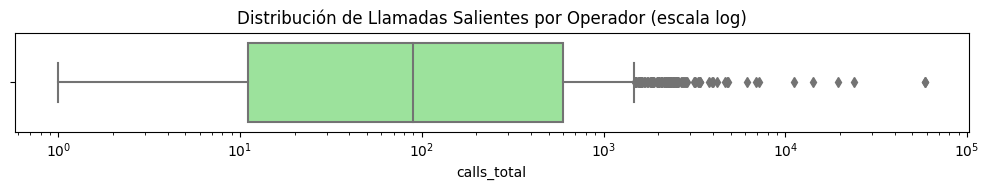

In [28]:
# Distribución de llamadas salientes por operador
calls_out_op = dataset_op[dataset_op['direction'] == 'out']
calls_out_per_op = calls_out_op.groupby('operator_id')['calls_count'].sum().reset_index(name='calls_total')
print(calls_out_per_op['calls_total'].describe())
    
plt.figure(figsize=(10, 2))
sns.boxplot(calls_out_per_op['calls_total'], color='lightgreen')
plt.title('Distribución de Llamadas Salientes por Operador (escala log)')
plt.xscale('log')
plt.tight_layout()
plt.show()


La distribución del volumen de llamadas salientes por operador es muy asimétrica, la mayoría de los operadores realizaron entre 1 y 597 llamadas con una medidana de 90, algunos casos atípicos mostraron hasta 58977.

count    222.000000
mean       4.432432
std        3.269554
min        1.000000
25%        1.000000
50%        3.000000
75%        7.000000
max       11.000000
Name: calls_total, dtype: float64


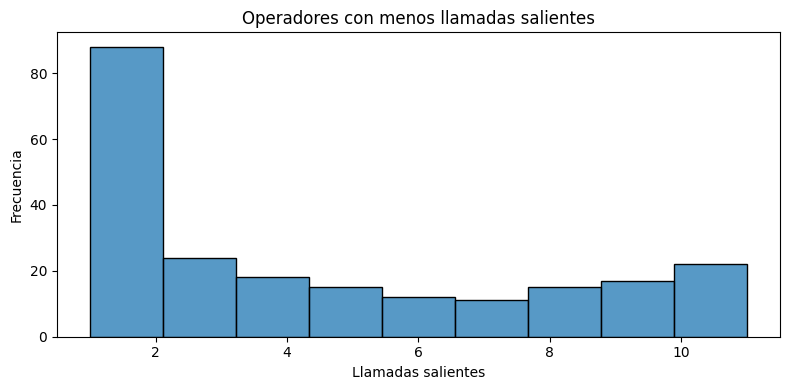

In [29]:
# Identifica operadores ineficaces de las llamadas salientes

# Selecciona valores por debajo del percentil 25
p25 = calls_out_per_op['calls_total'].quantile(0.25)
calls_out_op_inef = calls_out_per_op[calls_out_per_op['calls_total'] <= p25]
print(calls_out_op_inef['calls_total'].describe())

# Distribución de llamadas salientes de operadores con menos llamadas salientes
plt.figure(figsize=(8, 4))
sns.histplot(data=calls_out_op_inef, x='calls_total')
plt.title("Operadores con menos llamadas salientes")
plt.xlabel("Llamadas salientes")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


In [30]:
# Impacto de los operadores ineficientes en las llamadas salientes totales

# Suma de llamadas salientes el percentil ineficiente
calls_out_top = calls_out_per_op[calls_out_per_op['operator_id'].isin(calls_out_op_inef['operator_id'])].sum()

# Total de llamadas perdidas entrantes
total_calls_out = calls_out_per_op.sum()

print(f"Llamadas salientes de los operadores con menos llamadas: {calls_out_op_inef['calls_total'].sum()}")
impact_co = calls_out_top['calls_total'] / total_calls_out['calls_total'] * 100
print(f"Los operadores con menor volumen de llamadas salientes solo realizaron el {impact_co:.2f}% del total")


Llamadas salientes de los operadores con menos llamadas: 984
Los operadores con menor volumen de llamadas salientes solo realizaron el 0.16% del total



Aunque las llamadas salientes representan el 75,5 % del total de la gestión, el 25 % de los operadores con menor cantidad de llamadas realizadas tuvo una incidencia casi nula en el total. Sin embargo, ante la ausencia de un indicador que permita medir su nivel de cumplimiento respecto a la actividad asignada, no es posible evaluar objetivamente esta métrica ni establecer criterios claros para determinar la eficiencia de los operadores.

**Propuesta de identificación de operadores ineficaces**

Una vez realizado el análsis de eficiencia en las métricas estipuladas, llamadas perdidas entrantes, tiempos de espera de llamadas entrantes y volumen de llamadas salientes, se propone establecer una calificación global de ineficiencia con base en los siguientes criterios:

Un operador será considerado globalmente ineficaz si presenta desempeño deficiente en los dos indicadores clave, alto número de llamadas entrantes perdidas y tiempos de espera prolongados en la atención de llamadas entrantes.  En cuanto a la métrica llamadas salientes, su aplicación como criterio global no sería adecuado ya que no se tiene certeza sobre la asignación de esta responsabilidad a todos los operadores ni su nivel de cumplimiento.

In [31]:
# Establece conjuntos de operadores ineficientes en cada una de las métricas
missed_inef_ids = set(missed_calls_inef['operator_id'])
wait_inef_ids = set(wait_time_inef['operator_id'])

# Ineficiencia global: operadores que son ineficientes en llamadas perdidas Y tiempos de espera
inef_global = missed_inef_ids & wait_inef_ids
print(f"Operadores globalmente ineficientes: {len(inef_global)}")
print("IDs de operadores ineficientes:", sorted(list(inef_global)))


Operadores globalmente ineficientes: 50
IDs de operadores ineficientes: [884408.0, 888406.0, 888532.0, 888534.0, 888868.0, 890228.0, 894120.0, 896538.0, 897872.0, 899268.0, 900194.0, 900354.0, 900746.0, 902910.0, 904016.0, 905300.0, 906410.0, 907952.0, 911102.0, 911140.0, 911142.0, 912684.0, 914440.0, 918436.0, 920706.0, 924928.0, 924930.0, 924936.0, 924948.0, 924954.0, 926490.0, 930242.0, 932460.0, 934076.0, 934098.0, 934430.0, 935958.0, 937368.0, 937962.0, 939478.0, 944216.0, 944218.0, 944220.0, 944222.0, 944226.0, 945046.0, 948758.0, 951508.0, 958416.0, 958434.0]


#### 4. Prueba de hipótesis

**Llamadas perdidas**
* Hipotesis nula, Ho: La tasa promedio de llamadas perdidas entrantes es igual en operadores eficientes e ineficientes.
* Hipótesis alternativa, H1: La tasa promedio de llamadas perdidas entrantes es diferente entre ambos grupos.


In [32]:
# Crea columna 'inefficiency' en el dataset de tasas de llamadas perdidas (1 inefficient, 0 efficient)
missed_calls_merged['inefficiency'] = missed_calls_merged['operator_id'].isin(inef_global).astype(int)
missed_calls_merged[['rate_missed_calls', 'missed_calls_total']] = missed_calls_merged[['rate_missed_calls', 'missed_calls_total']].fillna(0)

# Calcula las tasas promedio por grupo de eficiencia
missed_rate_group = missed_calls_merged.groupby('inefficiency')['rate_missed_calls'].mean().reset_index()
print(f'Tasa promedio de llamadas perdidas (operadores eficientes): {missed_rate_group.iloc[0, 1]:.1f}')
print(f'Tasa promedio de llamadas perdidas (operadores ineficientes): {missed_rate_group.iloc[1, 1]:.1f}')


Tasa promedio de llamadas perdidas (operadores eficientes): 1.2
Tasa promedio de llamadas perdidas (operadores ineficientes): 9.0


In [33]:
# Tasas de cada grupo
efficient = missed_calls_merged[missed_calls_merged['inefficiency'] == 0]['rate_missed_calls']
inefficient = missed_calls_merged[missed_calls_merged['inefficiency'] == 1]['rate_missed_calls']

# Prueba t_test
t_stat, p_value = st.ttest_ind(efficient, inefficient, equal_var=False) 

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula (H₀). Hay evidencia estadísticamente significativa de que las tasas de llamadas perdidas difieren entre operadores eficientes e ineficientes.")
else:
    print("No se puede rechazar la hipótesis nula (H₀). No hay evidencia suficiente para afirmar que las tasas de llamadas perdidas son diferentes entre ambos grupos..")


T-statistic: -7.0224
P-value: 0.0000
Se rechaza la hipótesis nula (H₀). Hay evidencia estadísticamente significativa de que las tasas de llamadas perdidas difieren entre operadores eficientes e ineficientes.


**Tiempo de espera en llamadas entrantes**
* Hipotesis nula, Ho: El tiempo de espera de llamadas entrantes es igual en operadores eficientes e ineficientes.
* Hipótesis alternativa, H1: El tiempo de espera de llamadas entrantes es diferente entre los dos grupos.


In [34]:
# Une el tiempo promedio de espera por operador con dataset_op 

# Crea columna 'inefficiency' en el dataset de tiempos de espera de llamadas entrantes (1 inefficient, 0 efficient)
wait_time_merged['inefficiency'] = wait_time_merged['operator_id'].isin(inef_global).astype(int)

# Calcula los tiempos de espera por llamada por grupo de eficiencia
wait_time_group = wait_time_merged.groupby('inefficiency')['wait_time_by_call'].mean().reset_index()
print(f'Tasa promedio de llamadas perdidas (operadores eficientes): {wait_time_group.iloc[0, 1]:.1f}')
print(f'Tasa promedio de llamadas perdidas (operadores ineficientes): {wait_time_group.iloc[1, 1]:.1f}')


Tasa promedio de llamadas perdidas (operadores eficientes): 1689.8
Tasa promedio de llamadas perdidas (operadores ineficientes): 2585.3


In [35]:
# Tiempos de espera por llamada de cada grupo

efficient_ = wait_time_merged[wait_time_merged['inefficiency'] == 0]['wait_time_by_call']
inefficient_ = wait_time_merged[wait_time_merged['inefficiency'] == 1]['wait_time_by_call']

# Ejecuta t-test
t_stat, p_value = st.ttest_ind(efficient_, inefficient_, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Se rechaza H₀: hay diferencia significativa en el tiempo de espera entre operadores eficientes e ineficientes.")
else:
    print("No se puede rechazar H₀: no hay evidencia suficiente de diferencia.")

T-statistic: -7.5452
P-value: 0.0000
Se rechaza H₀: hay diferencia significativa en el tiempo de espera entre operadores eficientes e ineficientes.


*Definición de percentiles*

Se evaluaron los percentiles 50, 60, 70, 75, 80 y 85 como posibles umbrales para clasificar a los operadores ineficientes, basándose en dos métricas clave: la tasa de llamadas entrantes perdidas y el tiempo de espera de llamadas entrantes.  El análisis consideró tres criterios principales, la diferenciación entre las tasas promedio de los grupos eficientes e ineficientes, el impacto porcentual de cada grupo sobre el total de llamadas perdidas del sistema y el volumen de operadores identificados como ineficientes según cada combinación. 

Los valores fueron calculados manualmente y se presentan a continuación:

In [36]:
# Datos manuales del análisis de percentiles
data = {
    'No.': [1, 2, 3, 4, 5],  # combinaciones realizadas
    'Métrica 1': ["Missed Calls"] * 5,
    'Percentil MC': ["p85", "p80", "p70", "p60", "p50"],
    'Impacto MC %': [15.57, 19.87, 30.70, 37.84, 58.81],
    'No.Operadores MC': [11, 17, 27, 50, 73],
    'Eficientes MC ': [1.5, 1.5, 1.4, 1.2, 1.1],
    'Ineficientes MC': [17.8, 14.5, 11.2, 9.0, 8.1],
    'Métrica 2 ': ["Wait Time"] * 5,
    'Percentil WT': ["p70", "p70", "p70", "p60", "p50"],
    'Impacto WT %': [18.83, 18.83, 18.83, 27.13, 35.32],
    'Eficientes WT': [1730, 1720, 1705, 1689, 1682],
    'Ineficientes WT': [2983, 2986, 2931, 2585, 2367]}
# Crea dataset
df = pd.DataFrame(data)

df

,No.,Métrica 1,Percentil MC,Impacto MC %,No.Operadores MC,Eficientes MC,Ineficientes MC,Métrica 2,Percentil WT,Impacto WT %,Eficientes WT,Ineficientes WT
0,1,Missed Calls,p85,15.57,11,1.5,17.8,Wait Time,p70,18.83,1730,2983
1,2,Missed Calls,p80,19.87,17,1.5,14.5,Wait Time,p70,18.83,1720,2986
2,3,Missed Calls,p70,30.70,27,1.4,11.2,Wait Time,p70,18.83,1705,2931
3,4,Missed Calls,p60,37.84,50,1.2,9.0,Wait Time,p60,27.13,1689,2585
4,5,Missed Calls,p50,58.81,73,1.1,8.1,Wait Time,p50,35.32,1682,2367



Después de analizar diversas combinaciones de percentiles para segmentar a los operadores en eficientes e ineficientes, se concluye que la combinación más efectiva es utilizar Missed Calls (MC) y Wait Time por llamada (WT) ambos en el percentil 60. Esta configuración ofrece un muy buen equilibrio entre impacto, número de operadores clasificados y diferenciación clara entre grupos.
El impacto combinado, con MC en 37.84% y WT en 27.13%, permite una clasificación robusta y confiable, evitando los sesgos posibles en percentiles extremos.


#### 5. Conclusiones


El objetivo principal fue identificar los operadores con desempeño ineficiente evaluando tres métricas clave, número de llamadas entrantes perdidas, tiempo promedio de espera en llamadas entrantes y volumen de llamadas salientes realizadas.

Se buscó determinar qué operadores tienen una influencia considerable en la calidad deficiente del servicio, y si se presentan diferencias estadísticamente significativas en las métricas entre operadores eficientes e ineficientes.

**Principales hallazgos**

Datos generales de la operación:

+ Total de llamadas procesadas: 806,709
+ Operadores únicos: 1,092
+ Usuarios únicos: 307
+ Patrón semanal: mayor actividad de lunes a jueves, caída pronunciada el fin de semana.
+ Tendencia creciente en el volumen de llamadas a lo largo del periodo evaluado.
+ Proporción de llamadas salientes: 75.5%.
+ Proporción de llamadas externas: 98.2%s.
+ Tasa de llamadas perdidas: 46%.
+ Porcentaje de llamadas perdidas entrantes: 27.8%.
+ Llamadas perdidas entrantes por registro: 1.99
+ Tiempo de espera medio en llamadas entrantes por registro: 13 segundos.

Análsis por operador:

+ *Llamadas perdidas entrantes*
  
Llamadas perdidas entrantes de los operadores ineficientes: 350

Promedio de llamadas perdidas entrantes por operador: 1.99.  

El 37.84% de las llamadas perdidas se concentra en el 40% de los operadores con más llamadas perdidas

Promedio de llamadas perdidas entrantes de operadores ineficientes: 7.1.

La prueba de hipótesis concluye que hay diferencias significativas entre operadores eficientes e ineficientes en tasas de llamadas perdidas.

+ *Tiempos de espera en llamadas entrantes*

Tiempo promedio de espera por operador: 1443 seg. Se asume que el tiempo de espera es atribuible solamente al operador. 

El 40% de operadores menos eficientes reúne el 27.13% del tiempo de espera total.

Tiempo de espera de operadores menos eficientes: 2490
    
La prueba de hipótesis rechaza H₀, con evidencia estadística clara de diferencia en tiempos de espera entre grupos.

+ *Volumen del llamadas salientes*
  
Llamadas salientes por operador, mediana: 90

volumen de llamadas salientes de los operadorescon menos llamadas: 984

Llamadas salientes por operador con menos llamadas, mediana: 3

No es posible establecer criterios para determinar la eficiencia de los operadores en esta métrica, la ausencia de indicadores que permitan medir el nivel de cumplimiento frente a la actividad asignada hace que no pueda ser evaluada objetivamente.


+ *Análisis de eficiencia*

Se identificaron 50 operadores como globalmente ineficientes por presentar bajo desempeño tanto en llamadas perdidas como en tiempo de espera. Este grupo reducido debe ser priorizado para acciones correctivas ya que tienen gran impacto en la calidad del servicio. Existen diferencias significativas en el comportamiento entre operadores eficientes e ineficientes, respaldadas por pruebas estadísticas sólidas.


**Recomendaciones**

+ Realizar un seguimiento de la gestión de los 50 operadores globalmente ineficientes.
+ Evaluar posibles causas de los resultados en cuanto a formación y experiencia de los operadores, saturación de carga, o procedimientos técnicos.
+ Establecer un plan de mejora personalizado por operador.
+ Definir claramente los objetivos de llamadas salientes por operador para poder evaluar esa métrica de forma más objetiva y pueda incluirse en el análisis de eficiencia.
+ Explorar análisis complementarios como la segmentación por turnos o días de la semana, por tipo de usuario.

No se dispone de información sobre la distribución de turnos o carga horaria, lo que podría afectar el número de llamadas manejadas por cada operador.  Tampoco hay claridad sobre las responsabilidades de llamadas salientes, lo que limita la interpretación de esa métrica.
  
